In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib

from hyperopt import hp,fmin,tpe

N0 = 200000000

Primeiramente, implementamos um modelo SEIR discretizado levando em consideração a mortalidade. O modelo tem quatro parâmetros ($\alpha$, $\beta$, $\gamma$, $\mu$) e requer quatro condições iniciais ($S_0$, $E_0$, $I_0$, $R_0$). Como não temos dados para estimar o número de pessoas $E_0$ no período de incubação no tempo inicial e não temos dados do Ministério da Saúde no que tange ao número $R_0$ de recuperados no tempo inicial, trataremos essas condições iniciais como parâmetros a serem estimados. As condições iniciais que conhecemos são a população total $N_0$ e o número de infectados $I_0$.

In [3]:
def dstate(state, params):
    
    # state and params are numpy arrays
    
    [S, E, I, R] = state
    [alpha, beta, gamma, mu] = params
    
    N = sum(state)
    
    dS = - beta*S*I/N 
    dE = beta*S*I/N - alpha*E
    dI = alpha*E - (gamma + mu)*I
    dR = gamma*I
    
    return np.array([dS, dE, dI, dR])
    
def update_state(state, params):
    return state + dstate(state, params)

def state_history(T, initstate, params):
    if T == 0:
        return initstate
    else:
        for t in range(T):
            if t == 0:
                state_matrix = [initstate]
            else:
                state_matrix = np.vstack((state_matrix, update_state(state_matrix[t - 1][:], params)))
    model = pd.DataFrame(state_matrix, columns = ['S', 'E', 'I', 'R'])
    
    times = [t for t in range(T)]
    model.insert(0, 't', times)
    
    deaths = N0 - model['S'] - model['E'] - model['I'] - model['R']
    model.insert(5, 'D', deaths)
    
    return model

Vamos tentar estimar os parâmetros `params` e `initstate` a partir dos dados do Brasil. Usaremos apenas o número de casos confirmados ativos (como proxy para o número de infectados $I$) e o número de mortes, já que o Ministério da Saúde não disponibiliza o número de casos confirmados recuperados.

In [4]:
urllib.request.urlretrieve("https://covid.ourworldindata.org/data/ecdc/total_cases.csv", "cases.csv")
urllib.request.urlretrieve("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv", "deaths.csv")

cases = pd.read_csv("cases.csv")
deaths = pd.read_csv("deaths.csv")

In [5]:
condition = cases['Brazil'] >= 100

br_cases = cases[condition]
br_deaths = deaths[condition]
br_cases = br_cases['Brazil'].reset_index()
br_deaths = br_deaths['Brazil'].reset_index()

In [6]:
br_cases = br_cases.rename(columns={"Brazil": "I"})
br_deaths = br_deaths.rename(columns={"Brazil": "D"})

br_data = br_cases
br_data.insert(2, 'D', br_deaths['D'])

br_data

,index,I,D
0,75,121.0,0.0
1,76,200.0,0.0
2,77,234.0,0.0
3,78,291.0,1.0
4,79,428.0,4.0
5,80,621.0,6.0
6,81,904.0,11.0
7,82,1128.0,18.0
8,83,1546.0,25.0
9,84,1891.0,34.0


In [7]:
def loss_function(data, initstate, params):
    T = len(data)
    model = state_history(T, initstate, params)
    loss = sum((model['I'] - data['I'])**2)/(data['I'].std())**2 + sum((model['D'] - data['D'])**2)/(data['D'].std())**2
    return loss

In [8]:
space = {
    'alpha': hp.uniform('alpha', 0.01, 0.2),
    'beta': hp.uniform('beta', 0.2, 0.6),
    'gamma': hp.uniform('gamma', 0.001, 0.01),
    'mu': hp.uniform('mu', 0.001, 0.1),
    'E0': hp.loguniform('E0', np.log(100), np.log(1000)),
    'R0': hp.loguniform('R0', np.log(1), np.log(10)),
}

def loss(space):
    
    N0 = 200000000
    I0 = br_cases['I'][0]
    
    alpha = space['alpha']
    beta = space['beta']
    gamma = space['gamma']
    mu = space['mu']
    E0 = space['E0']
    R0 = space['R0']
    
    params = [alpha, beta, gamma, mu]
    initstate = [N0 - E0 - I0 - R0, E0, I0, R0]

    return loss_function(br_cases, initstate, params)

best = fmin(
    fn = loss,
    space = space,
    algo = tpe.suggest,
    max_evals = 2000
)

best

100%|██████████| 2000/2000 [01:00<00:00, 33.24trial/s, best loss: 0.4334341694608772]


{'E0': 998.8714131450748,
 'R0': 3.785190091701162,
 'alpha': 0.18305408289713238,
 'beta': 0.3339411364178846,
 'gamma': 0.006818523262002721,
 'mu': 0.006112463643189515}

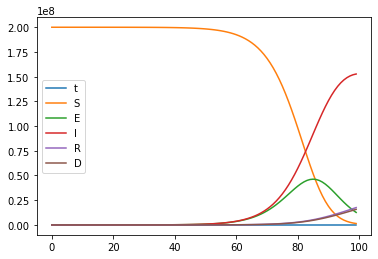

In [13]:
I0 = br_cases['I'][0]

params = [best['alpha'], best['beta'], best['gamma'], best['mu']]
initstate = [N0 - best['E0'] - I0 - best['R0'], best['E0'], I0, best['R0']]

states = state_history(100, initstate, params)

states.plot()

(0.0, 10000.0)

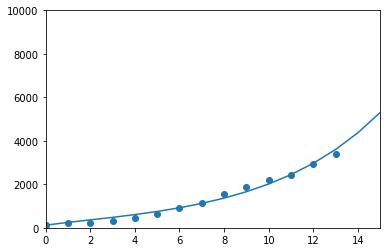

In [28]:
plt.plot(states['t'], states['I'], br_cases['I'], 'C0o')
plt.xlim(0,15)
plt.ylim(0, 10000)

(0.0, 130.0)

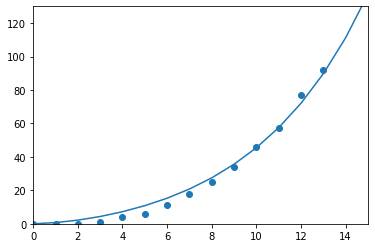

In [29]:
plt.plot(states['t'], states['D'], br_cases['D'], 'C0o')
plt.xlim(0,15)
plt.ylim(0, 130)

In [30]:
R0 = 1/(1 - states['I'].max()/N0)
print(R0)

6.680991867530429
